In [2]:
import math

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier




In [3]:
import csv
import pandas as pd



x_in = []
# x-position of each particle.
y_in = []
# y-position of each particle.
p_I = []
# particle current in [Amperes].
p_KP = []
# particle power in [Watts].

with open('quick_input.out') as file:
    reader = pd.read_csv(file,delimiter='\t',header=2,skipfooter=1,engine='python')
    
    columns = reader.columns.values
    listCol = list(columns)
    print(listCol)
    # Obtain the column headers.
    
    x_in = reader['x[in]']
    y_in = reader['y[in]']
    p_I  = reader['pI[A]']
    p_KP = reader['pKP[W]']
    # Take column headers and save separate lists for needed values.
    
x_min = min(x_in)
x_max = max(x_in)
y_min = min(y_in)
y_max = max(y_in)
# Built-in calculation for max and min of x,y components.
    
x_range = x_max - x_min
y_range = y_max - y_min
# Obtain the total length of both sides of our parameter space.
    
# x_range = round_up(x_range, 10)
# y_range = round_up(y_range, 10)
# Approximate the x,y ranges to a larger, nicer decimal value.
print(x_range,y_range)
    
ratio = (y_range / x_range)            
# Attempting to find subdivision interval unique to having dx == dy??




['pID', 'eTag', 'x[in]', 'y[in]', 'z[in]', 'vx/c', 'vy/c', 'vz/c', 'pI[A]', 'pKP[W]']
0.037525199999999995 0.0719152


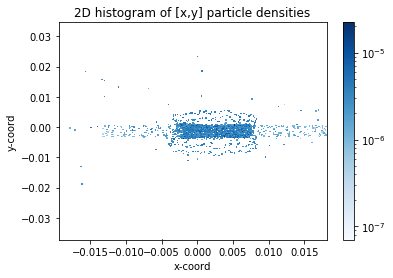

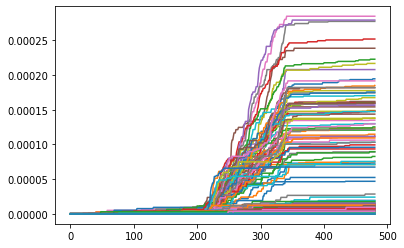

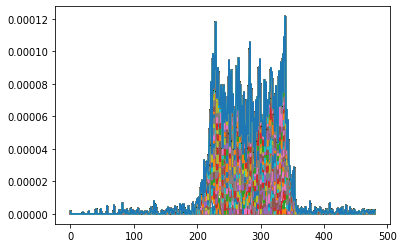

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

dl = 0.000078*1
# [inches], two microns * constant

(a, b, c, d) = plt.hist2d(x_in,y_in,bins=[np.arange(x_min,x_max,dl),
                           np.arange(y_min,y_max,dl)],
                           weights=p_I,cmap='Blues',
                           norm=colors.LogNorm())
density = plt.colorbar()
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.title('2D histogram of [x,y] particle densities')
plt.show()

# Projected histograms in x and y directions.
chx, chy = a.cumsum(axis=0), a.cumsum(axis=1)
hx, hy = a.sum(axis=0), a.sum(axis=1)

plt.plot(chx)
# plt.axis([x_min,x_max,y_min,y_max])
plt.show()
# print(hx)

plt.plot(chy)
# plt.axis([x_min,x_max,y_min,y_max])
plt.show()
# print(hy)






In [613]:
def bandwidth(x_in):
    particles = len(x_in)
    constant = (3000 / 0.1)
    bandwidth = (particles / constant)
    
    return bandwidth
    

FWHM_x: 0.010781772126063368
FWHM_y: 0.005725382172496123


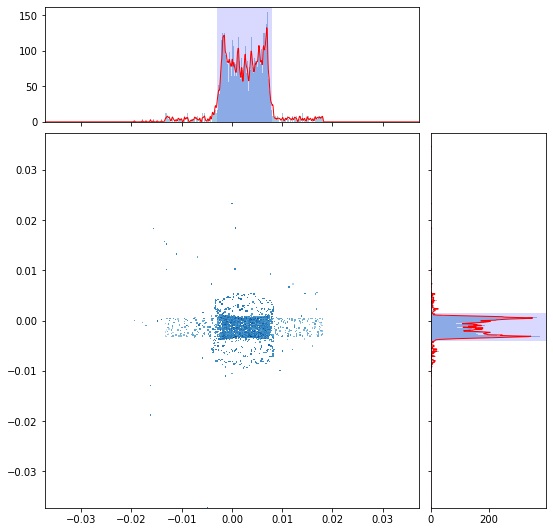

In [614]:
from statsmodels.stats.weightstats import DescrStatsW
import scipy.stats as stats

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the 2D histogram plot:
axScatter.hist2d(x_in,y_in,bins=[np.arange(x_min,x_max,dl),
                           np.arange(y_min,y_max,dl)],
                           weights=p_I,cmap='Blues',
                           norm=colors.LogNorm())

# now determine nice limits by hand:
binwidth = dl
xymax = np.max([np.max(np.fabs(x_in)), np.max(np.fabs(y_in))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)

(n,x,_) = axHistx.hist(x_in, bins=bins, density=True,alpha=0.4)
for width_factor in [bandwidth(x_in)]:
    kde = stats.gaussian_kde(x_in)
    f = kde.covariance_factor()
    bw = f * x_in.std() * width_factor
    
    x_curve = axHistx.plot(bins, kde_sklearn(x_in, bins, bw), ('red'), linewidth=1, alpha=1)
    xx_out = x_curve[0].get_xdata()
    xy_out = x_curve[0].get_ydata()
    
    weighted_x_stats = DescrStatsW(xx_out,weights=xy_out)
    std = weighted_x_stats.std
    fit_mu = weighted_x_stats.mean
    FWHM = 2*np.sqrt(2*np.log(2))*std
    print ("FWHM_x:", FWHM)
    
    axHistx.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.15)

    
    
(n,y,_) = axHisty.hist(y_in, bins=bins, orientation='horizontal', density=True,alpha=0.4)
for width_factor in [bandwidth(x_in)]:
    kde = stats.gaussian_kde(y_in)
    f = kde.covariance_factor()
    bw = f * y_in.std() * width_factor
    
    y_curve = axHisty.plot(kde_sklearn(y_in, bins, bw), bins, ('red'), linewidth=1, alpha=1)
    yx_out = y_curve[0].get_xdata()
    yy_out = y_curve[0].get_ydata()

    weighted_y_stats = DescrStatsW(yy_out,weights=yx_out)
    std = weighted_y_stats.std
    fit_mu = weighted_y_stats.mean
    FWHM = 2*np.sqrt(2*np.log(2))*std
    print ("FWHM_y:", FWHM)
    
    axHisty.axhspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.15)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
plt.show()

# Need to fit the FWHM to the gaussian and not just the input data!!!


std: 0.004578597056201662
mean: 0.0025026347692282866
FWHM_x: 0.010781772126063368


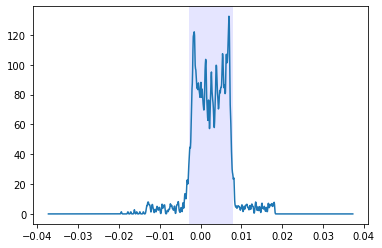

std: 0.0024313459470406682
mean: -0.001286683014460906
FWHM_y: 0.005725382172496123


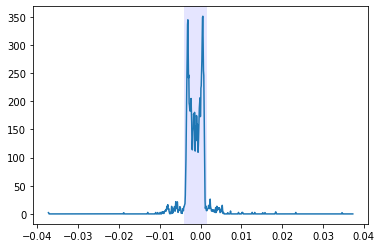

0.002502634769228329
FWHM_x: 0.0107795918822097


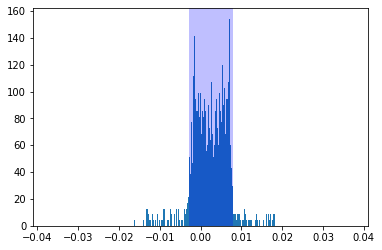

-0.0012872854114746512
FWHM_y: 0.005735293939890718


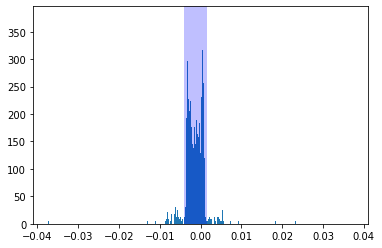

In [599]:
# Testing for FWHM implementation!!!


weighted_x_stats = DescrStatsW(xx_out,weights=xy_out)
# Currently using saved x_out from .get_xydata() of axHist plots.
plt.plot(xx_out,xy_out)
std = weighted_x_stats.std
print('std:', std)
fit_mu = weighted_x_stats.mean
print('mean:', fit_mu)
FWHM = 2*np.sqrt(2*np.log(2))*std
print ("FWHM_x:", FWHM)
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.1)

plt.show()


weighted_y_stats = DescrStatsW(yy_out,weights=yx_out)
plt.plot(yy_out,yx_out)
std = weighted_y_stats.std
print('std:', std)
fit_mu = weighted_y_stats.mean
print('mean:', fit_mu)
FWHM = 2*np.sqrt(2*np.log(2))*std
print ("FWHM_y:", FWHM)
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.1)

plt.show()





plt.hist(x_in, bins=bins, density=True)
std = np.std(x_in)
fit_mu = np.mean(x_in)
print(fit_mu)
FWHM = 2*np.sqrt(2*np.log(2))*std
print ("FWHM_x:", FWHM)
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.25)

plt.show()

plt.hist(y_in, bins=bins, density=True)
std = np.std(y_in)
fit_mu = np.mean(y_in)
print(fit_mu)
FWHM = 2*np.sqrt(2*np.log(2))*std
print ("FWHM_y:", FWHM)
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='b', alpha=0.25)

plt.show()